In [1]:
import gzip
import tqdm.notebook as tqdm
from collections import defaultdict
import json

f = open("../data/goodreads_reviews_spoiler.json")
lines = []
for i in tqdm.tqdm(range(1378033)):
    lines.append(json.loads(f.readline()))

In [2]:
print(lines[0])

{'user_id': '8842281e1d1347389f2ab93d60773d4d', 'timestamp': '2017-08-30', 'review_sentences': [[0, 'This is a special book.'], [0, 'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'], [0, 'This is what I love about good science fiction - it pushes your thinking about where things can go.'], [0, "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."], [0, 'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'], [0, 'It is a book about science, and aliens.'], [0, 'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'], [1, 'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though.'], [1, 'But what woul

In [3]:
# remove data before 2010
new_lines = []
for line in lines:
    if int(line['timestamp'].split('-')[0]) < 2011:
        pass
    else:
        new_lines.append(line)

In [4]:
lines = new_lines
del new_lines

In [5]:
import random
len(lines)
random.shuffle(lines)
test_size = int(len(lines)*0.2)
test_lines = lines[:test_size]
valid_lines = lines[test_size:test_size+10000]
train_lines = lines[test_size+10000:]

In [6]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()
punctuation = set(string.punctuation)

def clean_review(sentence):
    return ''.join([c for c in sentence.lower() if c not in punctuation])

In [7]:
import nltk
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

words = defaultdict(int)

for line in tqdm.tqdm(train_lines):
    for sentence in line['review_sentences']:
        sentence = clean_review(sentence[1])
        if (sentence != '') and (sentence is not None):
            for word in sentence.split():
                    if word not in cachedStopWords:
                        words[word] += 1

Let's stem the words.

In [8]:
stem_words = defaultdict(int)
map_stem_words = {}
for word in tqdm.tqdm(list(words.keys())):
    stem_word = stemmer.stem(word)
    map_stem_words[word] = stem_word
    stem_words[stem_word] += words[word]

Get the most popular 100 words.

In [9]:
counts = [(stem_words[w], w) for w in stem_words]
counts.sort()
counts.reverse()
word_bags = counts[:100]
popular_words = set([word[1]for word in word_bags])

In [13]:
import json
with open('../data/popular_words.txt', 'w+') as file:
    json.dump(list(zip(range(100), word_bags)), file)

Compute splitted reviews.

In [14]:
reviews = defaultdict(set)
for line in tqdm.tqdm(train_lines):
    book_id = line['book_id']
    sentences = line['review_sentences']
    label = line['has_spoiler']
    paragraph = ''
    for sentence in sentences:
        paragraph = paragraph + " " + clean_review(sentence[1])
    reviews[book_id].add((paragraph, label))

In [16]:
splitted_review = defaultdict(set)
for book_id in tqdm.tqdm(reviews):
    for paragraph, label in reviews[book_id]:
        new_paragraph = []
        for word in paragraph.split():
            if word in map_stem_words:
                new_paragraph.append(map_stem_words[word])
        splitted_review[book_id].add((" ".join(new_paragraph), label))

In [ ]:
def save_data(name, train_data, train_label, valid_data, valid_label, test_data, test_label):
    with open('../data/cleaned_inputs' + name + '.pkl', 'w+') as f:
        json.dump({'train_data':train_data, 
                   'train_label':train_label,
                  'test_data':test_data,
                  'test_label':test_label,
                  'valid_data':valid_data,
                  'valid_label':valid_label}, f)

# 0 Extract Word Count

Let's compute the word count for each review.

In [18]:
popular_words = list(popular_words)

def feat_count(words, book_id):
    feat = [0] * 100
    for word in words:
        if word in map_stem_words:
            word = map_stem_words[word]
        else:
            continue
        if word in popular_words:
            word_id = popular_words.index(word)
            feat[word_id] += 1
    feat = feat + [1]
    return feat

def get_data_and_label(target_lines, feat):
    target_data = []
    target_label = []
    for line in tqdm.tqdm(target_lines):
        book_id = line['book_id']
        label = line['has_spoiler']
        whole_review = ''
        for sentence in line['review_sentences']:
            whole_review = whole_review + ' ' + clean_review(sentence[1])
        target_data.append(feat(whole_review.split(), book_id))
        target_label.append(label)
    return target_data, target_label

train_data, train_label = get_data_and_label(train_lines, feat_count)
test_data, test_label = get_data_and_label(test_lines, feat_count)

In [94]:
len(valid_lines)

10000

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lrmod = LogisticRegression(class_weight='balanced', multi_class='auto', solver='lbfgs', C=10)
lrmod.fit(train_data, train_label)
acc = lrmod.score(test_data, test_label)
prob = lrmod.predict_proba(test_data)
prob = prob[:,1].reshape(-1)
fpr, tpr, thresholds = metrics.roc_curve(test_label, prob)
auc = metrics.auc(fpr, tpr)
print(acc, auc)

0.7705925948333232 0.7718477188173347


In [40]:
sort_index_count = sorted(list(range(101)),key=list(lrmod.coef_.reshape(-1)).__getitem__, reverse=True)
coef_count = list(lrmod.coef_.reshape(-1))

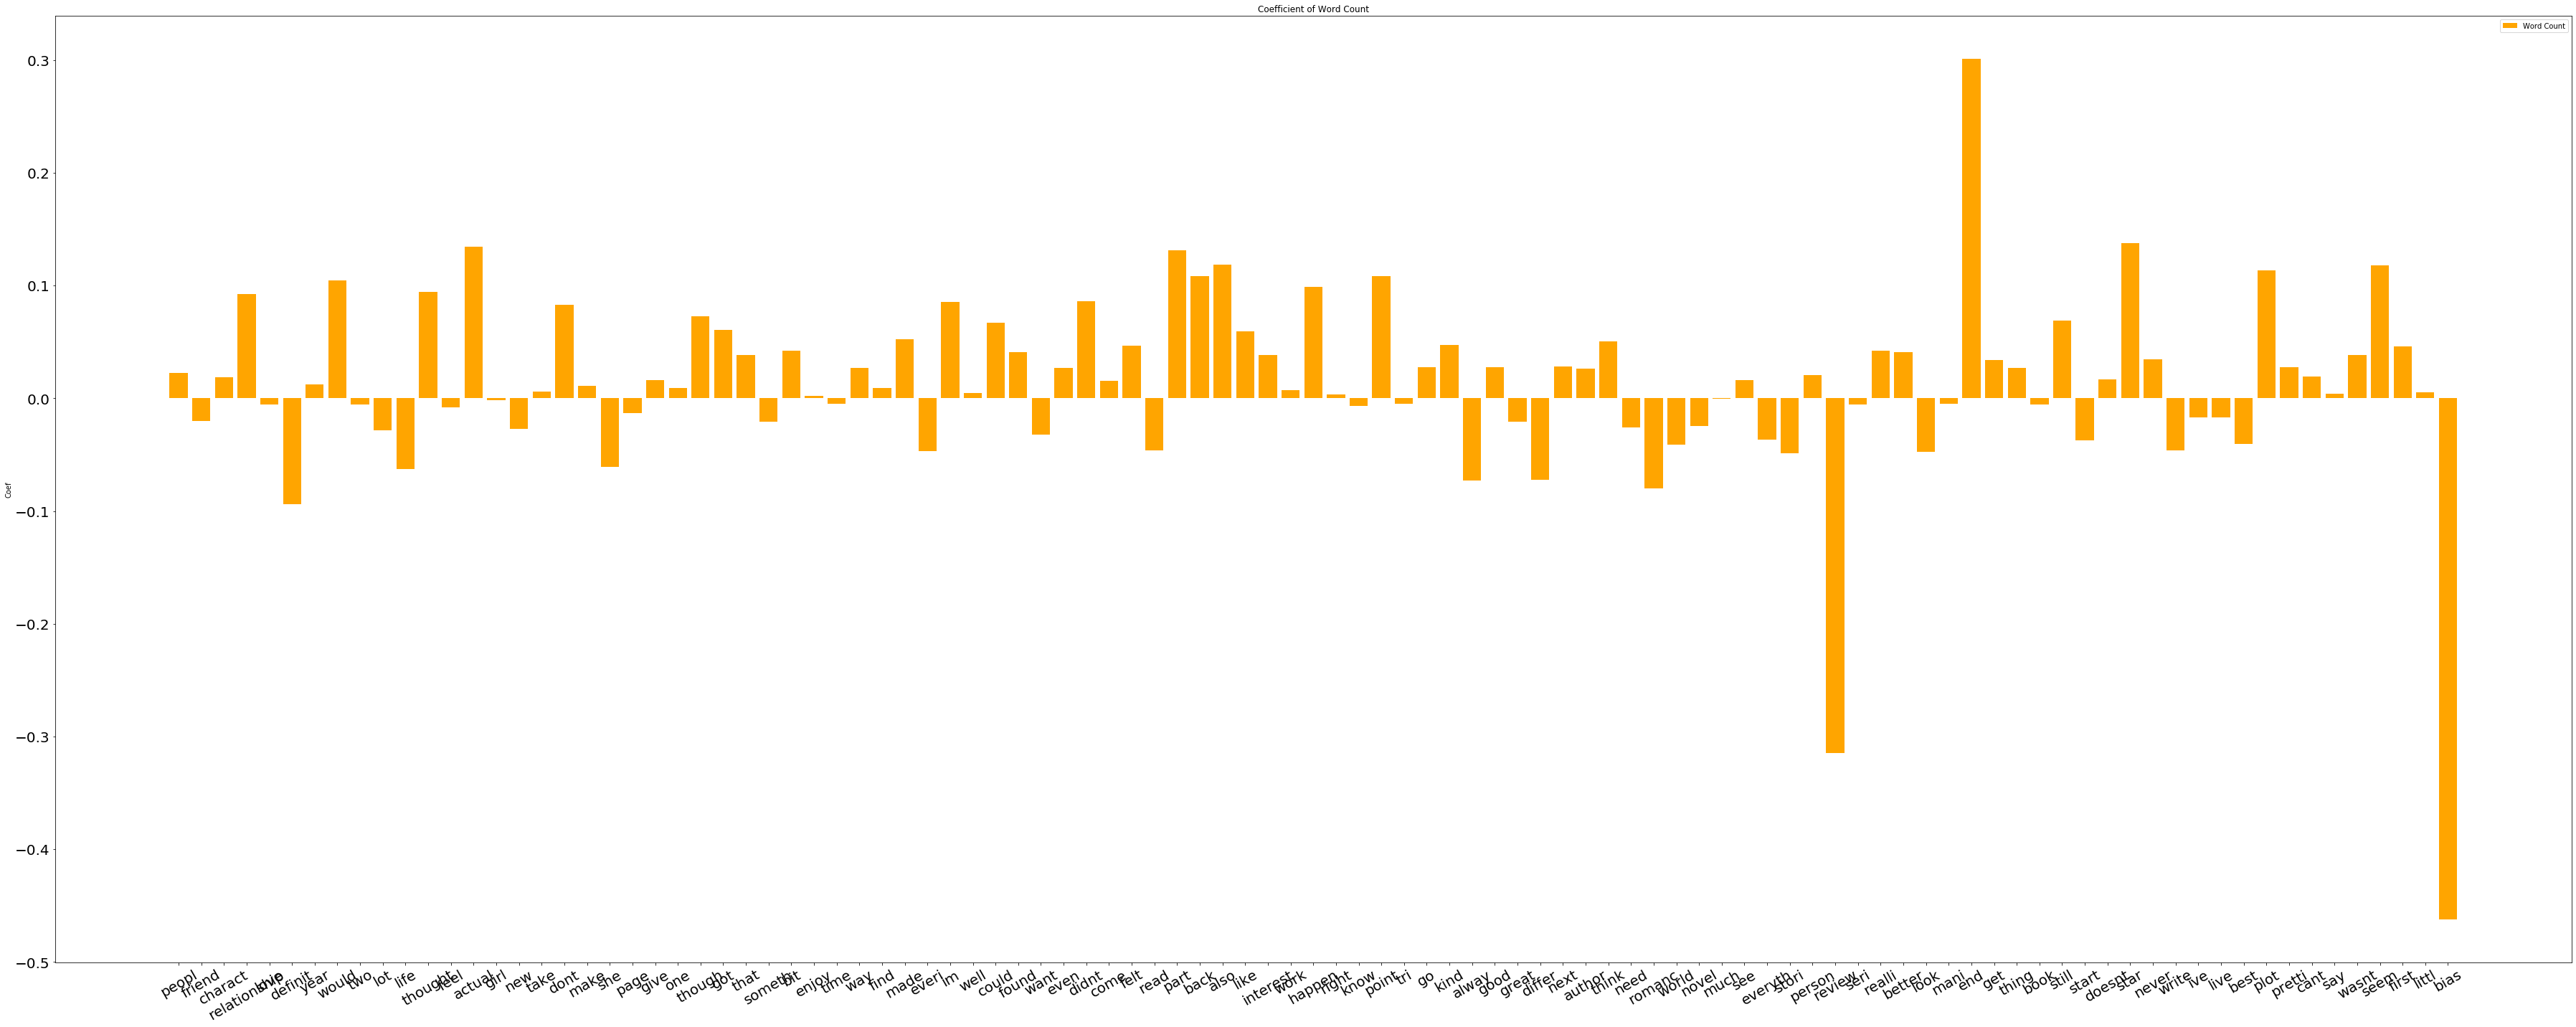

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
labels = popular_words + ['bias']
theta_word_count = coef_count
theta_df_iif = coef_df_iif

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(50, 20))
rects1 = ax.bar(list(range(101)), theta_word_count, label='Word Count', color='orange')
ax.tick_params(axis='both', which='major', labelsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coef')
ax.set_title('Coefficient of Word Count')
ax.set_xticks(x)
plt.setp(ax.get_xticklabels(), rotation=30)
ax.set_xticklabels(labels)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [89]:
popular_words[73]

'review'

In [88]:
coef_df_iif.index(min(coef_df_iif))

73

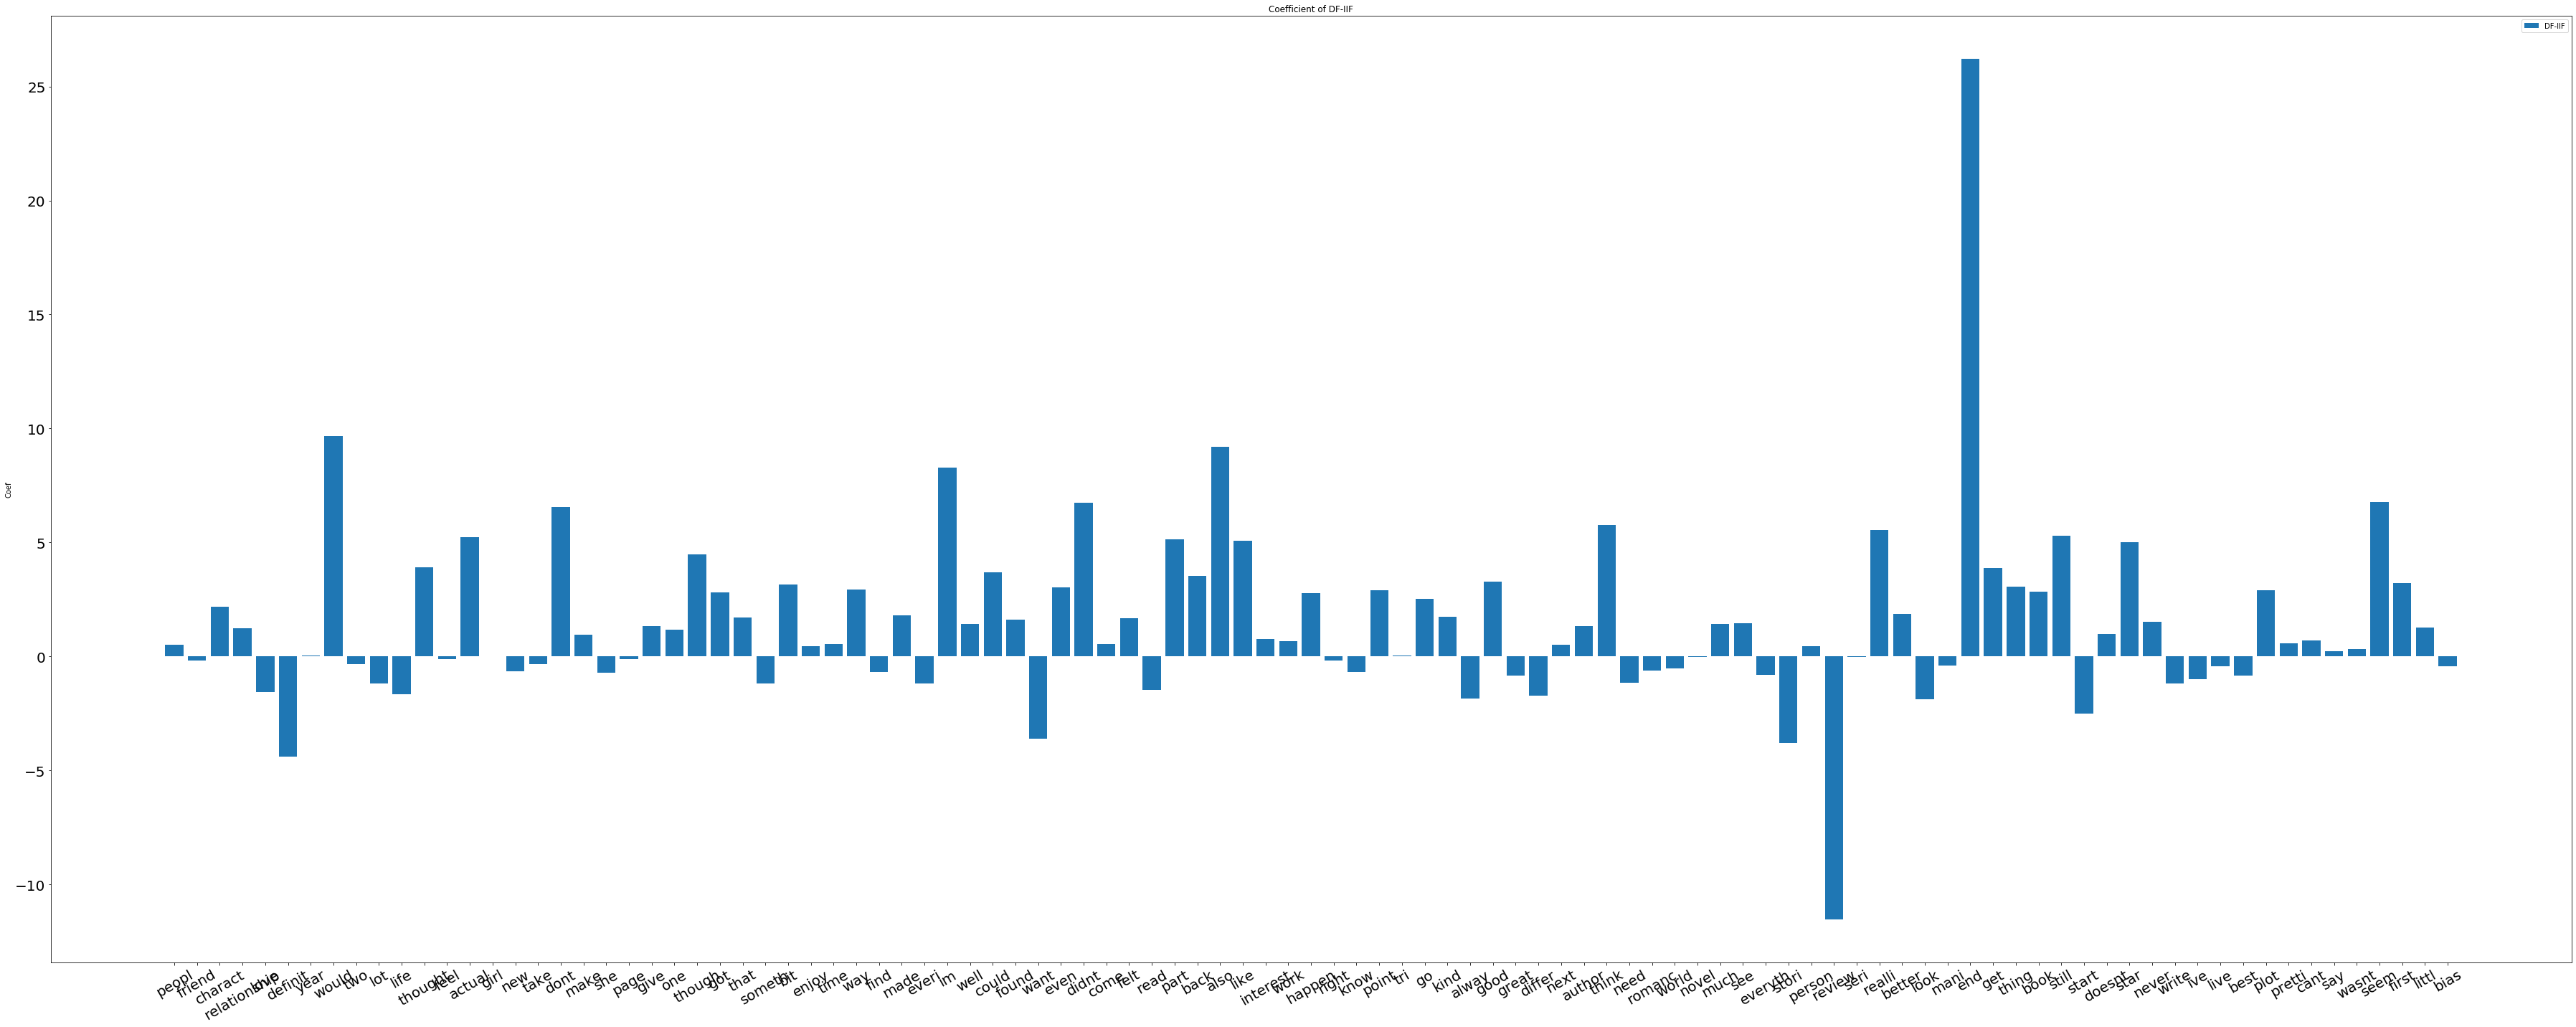

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
labels = popular_words + ['bias']
theta_word_count = coef_count
theta_df_iif = coef_df_iif

x = np.arange(len(labels))  # the label locations


fig, ax = plt.subplots(figsize=(50, 20))
rects1 = ax.bar(list(range(101)), theta_df_iif, label='DF-IIF')
ax.tick_params(axis='both', which='major', labelsize=20)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coef')
ax.set_title('Coefficient of DF-IIF')
ax.set_xticks(x)
plt.setp(ax.get_xticklabels(), rotation=30)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [84]:
import json
with open('../data/popular_words.txt', 'w+') as file:
    json.dump(list(zip(range(100), popular_words)), file)

In [ ]:
save_data("count", train_data, train_label, valid_data, valid_label, test_data, test_label)

#  1 Extract DF-IIF

Let's compute DF.

In [36]:
count_word_in_book = defaultdict(int)
for book_id in tqdm.tqdm(splitted_review):
    for paragraph, _ in splitted_review[book_id]:
        all_words = set(paragraph.split())
        for word in (set(all_words)&set(popular_words)):
                count_word_in_book[word+"-"+book_id] += 1

DF = defaultdict(float)
for book_id in tqdm.tqdm(splitted_review):
    d_i = len(splitted_review[book_id])
    for word in popular_words:
        if (word+"-"+book_id) in count_word_in_book:
            DF[word+"-"+book_id] = count_word_in_book[word+"-"+book_id] / d_i

Let's compute IIF.

In [37]:
import numpy as np
IF = defaultdict(float)
epsilon = 1e-5
for book_id in tqdm.tqdm(splitted_review):
    whole_paragraph = ''
    for paragraph, _ in splitted_review[book_id]:
        whole_paragraph += ' ' + paragraph
    all_words = set(whole_paragraph.split())
    for word in (all_words & set(popular_words)):
        IF[word] += 1

IIF = defaultdict(float)    
for word in IF:
    IIF[word] = - np.log((IF[word] + epsilon) / (len(splitted_review) + epsilon))

Let's compute DF-IIF.

In [38]:
DF_IIF = defaultdict(float)
for word_book_id in tqdm.tqdm(DF):
    word, book_id = word_book_id.split("-")
    DF_IIF[word_book_id] = DF[word_book_id] * IIF[word]

In [42]:
popular_words = list(popular_words)

def feat_df_iif(words, book_id):
    feat = [0] * 100
    for word in words:
        if word in map_stem_words:
            word = map_stem_words[word]
        else:
            continue
        if word in popular_words:
            word_id = popular_words.index(word)
            feat[word_id] += DF_IIF[word+'-'+book_id]
    feat = feat + [1]
    return feat

def get_data_and_label(target_lines, feat):
    target_data = []
    target_label = []
    for line in tqdm.tqdm(target_lines):
        book_id = line['book_id']
        label = line['has_spoiler']
        whole_review = ''
        for sentence in line['review_sentences']:
            whole_review = whole_review + ' ' + clean_review(sentence[1])
        target_data.append(feat(whole_review.split(), book_id))
        target_label.append(label)
    return target_data, target_label

train_data, train_label = get_data_and_label(train_lines, feat_df_iif)
test_data, test_label = get_data_and_label(test_lines, feat_df_iif)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lrmod = LogisticRegression(class_weight='balanced', multi_class='auto', solver='lbfgs', C=10)
lrmod.fit(train_data, train_label)
acc = lrmod.score(test_data, test_label)
prob = lrmod.predict_proba(test_data)
prob = prob[:,1].reshape(-1)
fpr, tpr, thresholds = metrics.roc_curve(test_label, prob)
auc = metrics.auc(fpr, tpr)
print(acc, auc)

/Users/rainorangelemon/anaconda3/envs/RecSys/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7855965273156271 0.7600148517237886


In [44]:
sort_index_df_iif = sorted(list(range(101)),key=list(lrmod.coef_.reshape(-1)).__getitem__, reverse=True)
coef_df_iif = list(lrmod.coef_.reshape(-1))

In [ ]:
save_data("DF-IIF", train_data, train_label, valid_data, valid_label, test_data, test_label)

# 1.1 Draw Histogram between Spoiler and Non-Spoiler

In [45]:
spoiler_DF_IIF = 0
spoiler_words = 0
no_spoiler_DF_IIF = 0
no_spoiler_words = 0 
for book_id in tqdm.tqdm(splitted_review):
    for paragraph, label in splitted_review[book_id]:
        for word in paragraph.split():
            key = word+'-'+book_id
            if key in DF_IIF:
                value = DF_IIF[key]
            else:
                continue
            if label:
                spoiler_words += 1
                spoiler_DF_IIF += value
            else:
                no_spoiler_words += 1
                no_spoiler_DF_IIF += value

In [37]:
spoiler_DF_IIF = 0
spoiler_words = 0
no_spoiler_DF_IIF = 0
no_spoiler_words = 0 
for line in tqdm.tqdm(train_lines):
    book_id = line['book_id']
    for sentence in line['review_sentences']:
        label = sentence[0]
        sentence = clean_review(sentence[1])
        if (sentence != '') and (sentence is not None):
            for word in sentence.split():
                if word in map_stem_words:
                    word = map_stem_words[word]
                else:
                    continue
                key = word+'-'+book_id
                if key in DF_IIF:
                    value = DF_IIF[key]
                else:
                    continue
                if label:
                    spoiler_words += 1
                    spoiler_DF_IIF += value
                else:
                    no_spoiler_words += 1
                    no_spoiler_DF_IIF += value

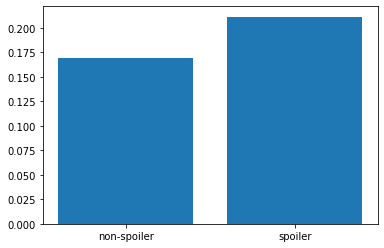

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.arange(2)
fig, ax = plt.subplots()
plt.bar(x, [no_spoiler_DF_IIF/no_spoiler_words, spoiler_DF_IIF/spoiler_words])
plt.xticks(x, ('non-spoiler', 'spoiler'))
plt.show()

# 2 Conditional DF

### 2.1 ban words

In [51]:
words_no_spoiler = defaultdict(int)


for book_id in tqdm.tqdm(splitted_review):
    for paragraph, label in splitted_review[book_id]:
        if not label:
            for word in paragraph.split():
                words_no_spoiler[word] += 1
counts = [(words_no_spoiler[w], w) for w in words_no_spoiler]
counts.sort()
counts.reverse()

ban_words = [x[1] for x  in counts[:100]]

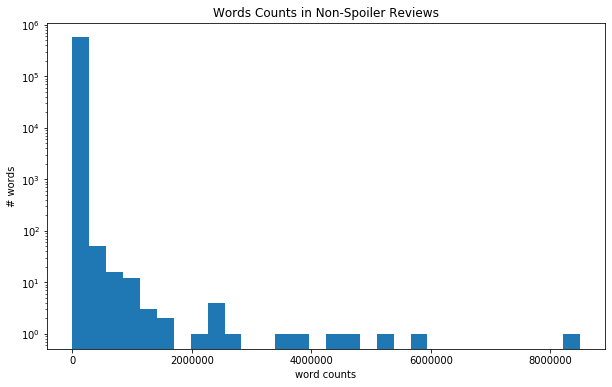

In [60]:
fig = plt.figure(figsize=(10, 6))
plt.hist(words_no_spoiler.values(), bins=30)
plt.yscale('log', nonposy='clip')
plt.ylabel('# words')
plt.xlabel('word counts')
plt.title("Words Counts in Non-Spoiler Reviews")
plt.show()

In [61]:
counts[:10]

[(8488997, 'the'),
 (5692429, 'and'),
 (5294510, 'i'),
 (4593418, 'to'),
 (4413053, 'a'),
 (3796890, 'of'),
 (3430832, 'it'),
 (2584764, 'that'),
 (2501713, 'is'),
 (2462311, 'in')]

### 2.2 word pool for each book

In [ ]:
words_of_book = defaultdict(lambda: defaultdict(int))

for line in tqdm.tqdm(train_lines):
    book_id = line['book_id']
    
    for sentence in line['review_sentences']:
        sentence = clean_review(sentence[1])
        
        if (sentence != '') and (sentence is not None):
            for word in sentence.split():
                if word not in cachedStopWords:
                    words_of_book[book_id][word]+=1
popular_of_book = defaultdict(list)
map_stem_words = {}
for book_id in tqdm.tqdm(words_of_book):
    stem_words = defaultdict(int)
    
    words = words_of_book[book_id]
    for word in list(words.keys()):
        try:
            stem_word = map_stem_words[word]
        except:
            stem_word = stemmer.stem(word)
            map_stem_words[word] = stem_word
        stem_words[stem_word] += words[word]
    counts = [(stem_words[w], w) for w in stem_words]
    counts.sort()
    counts.reverse()
    popular_of_book[book_id] = counts
    
word_pool_of_book = defaultdict(list)
for book_id in tqdm.tqdm(popular_of_book):
    num = 0
    for _, word in  popular_of_book[book_id]:
        if word not in ban_words:
            word_pool_of_book[book_id].append(word)
            num+=1
            if num==500:
                break

### 2.3 compute conditional DF

In [ ]:
count_spoiler = defaultdict(int)
count_total_review = defaultdict(int)
for line in tqdm.tqdm(train_lines):
    book_id = line['book_id']
    label = line['has_spoiler']
    for sentence in line['review_sentences']:
        sentence = clean_review(sentence[1])
        if (sentence != '') and (sentence is not None):
            for word in sentence.split():
                if word in map_stem_words:
                    word = map_stem_words[word]
                else:
                    continue
                if word in word_pool_of_book[book_id]:
                    count_total_review[word+'-'+book_id] += 1
                if label == True:
                    count_spoiler[word+'-'+book_id] += 1
                    
conditional_DF = defaultdict(float)
for key in count_total_review:
    conditional_DF[key] = count_spoiler[key] / count_total_review[key]

In [21]:
def feat_con_df(words, book_id):
    feat = [0] * 500
    for word in words:
        if word in map_stem_words:
            word = map_stem_words[word]
        else:
            continue
        if word in word_pool_of_book[book_id]:
            word_id = word_pool_of_book[book_id].index(word)
            feat[word_id] += conditional_DF[word+'-'+book_id]
    feat = feat + [1]
    return feat

train_data, train_label = get_data_and_label(train_lines, feat_con_df)
valid_data, valid_label = get_data_and_label(valid_lines, feat_con_df)
test_data, test_label = get_data_and_label(test_lines, feat_con_df)

In [ ]:
save_data("con-DF", train_data, train_label, valid_data, valid_label, test_data, test_label)

## 2.1 Histogram for Conditional DF

In [47]:
spoiler_CDF = 0
spoiler_words = 0
no_spoiler_CDF = 0
no_spoiler_words = 0 
for book_id in tqdm.tqdm(splitted_review):
    for paragraph, label in splitted_review[book_id]:
        for word in paragraph.split():
            key = word+'-'+book_id
            if key in conditional_DF:
                value = conditional_DF[key]
            else:
                continue
            if label:
                spoiler_words += 1
                spoiler_CDF += value
            else:
                no_spoiler_words += 1
                no_spoiler_CDF += value

NameError: name 'conditional_DF' is not defined

# 3 Normalized Frequency

In [22]:
count_spoiler_review = defaultdict(int)
count_review = defaultdict(int)
for line in tqdm.tqdm(train_lines):
    book_id = line['book_id']
    label = line['has_spoiler']
    count_review[book_id] += 1
    if label == True:
        count_spoiler_review[book_id] += 1
normalized_freq = defaultdict(float)
for key in count_total_review:
    book_id = key.split('-')[1]
    normalized_freq[key] = conditional_DF[key]*(count_review[book_id]+1) / (count_spoiler_review[book_id]+1)


In [24]:
def feat_normalf(words, book_id):
    feat = [0] * 500
    for word in words:
        if word in map_stem_words:
            word = map_stem_words[word]
        else:
            continue
        if word in word_pool_of_book[book_id]:
            word_id = word_pool_of_book[book_id].index(word)
            feat[word_id] += normalized_freq[word+'-'+book_id]
    feat = feat + [1]
    return feat
train_data, train_label = get_data_and_label(train_lines, feat_normalf)
test_data, test_label = get_data_and_label(test_lines, feat_normalf)
valid_data, valid_label = get_data_and_label(valid_lines, feat_normalf)

In [ ]:
save_data("Norm-F", train_data, train_label, valid_data, valid_label, test_data, test_label)

## 4 Normalized Freq+ Hist

In [25]:
def feat_normalf_hist(words, book_id, bin_=30):
    feat = [0] * 500
    for word in words:
        if word in map_stem_words:
            word = map_stem_words[word]
        else:
            continue
        if word in word_pool_of_book[book_id]:
            word_id = word_pool_of_book[book_id].index(word)
            feat[word_id] += normalized_freq[word+'-'+book_id]
    new_feat = [0] * bin_
    feat = np.array(feat)
    for i in range(bin_):
        new_feat[i] = np.log(1+np.sum(np.logical_and(feat>=(150*(i)/(bin_)), feat<=(150*(i+1)/(bin_)))))
    new_feat = new_feat / np.sum(new_feat)
    new_feat = new_feat + [1]
    return new_feat
train_data, train_label = get_data_and_label(train_lines, feat_normalf_hist)
test_data, test_label = get_data_and_label(test_lines, feat_normalf_hist)
valid_data, valid_label = get_data_and_label(valid_lines, feat_normalf_hist)

In [ ]:
train_data = [list(data) for data in train_data]
valid_data = [list(data) for data in valid_data]
test_data = [list(data) for data in test_data]

In [ ]:
save_data('Norm-F-HIST', train_data, train_label, valid_data, valid_label, test_data, test_label)